In [1]:
# Citations
# GBIF.org (15 June 2025) GBIF Occurrence Download  https://doi.org/10.15468/dl.mhxdcy
# Data was obtained from GBIF-NZ, it includes records from 6 datasets: iNaturalist Research-grade Observations Observation.org, Nature data from around the World, Auckland Museum Land Vertebrates Collection, Xeno-canto - Bird sounds from around the world, NABU|naturgucker, MVZ Egg and Nest Collection (Arctos)
# There were 4258 occurances in the original dataset, but this was reduced to 4202 occurances as a result of data cleaning.
# Of the original 4258 occurances, 581 were takahe (Porphyrio hochstetteri) and 3621 were pukeko (Porphyrio melanotus subsp. melanotus).
# In the cleaned dataset 550 were takahe (Porphyrio hochstetteri) and 3557 were pukeko (Porphyrio melanotus subsp. melanotus).
# The data cleaning and downloading of the images was performed in Rstudio.
# Made using Python version 3.12.9


In [ ]:
# loading packages, using python 3.12.9
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [ ]:
# Transforming the data by resizing the images, converting the images to tensors and normalizing the images
Transform_data = transforms.Compose([
    # Resizes images to 600 by 600 pixels
    transforms.Resize((600, 600)),
    # randomly horizontally flips images
    transforms.RandomHorizontalFlip(p = 0.3),
    # randomly rotates images
    transforms.RandomRotation(degrees = (0, 180)),
    # Randomly alters the visual appearance of the images during training
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
    # turns images into tensors
    transforms.ToTensor(),
    # Normalises the data
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Random data augmentation techniques are not used on the validation set to avoid overfitting
V_Transform_data = transforms.Compose([
    # Resizes images to 600 by 600 pixels
    transforms.Resize((600, 600)),
    # turns images into tensors
    transforms.ToTensor(),
    # Normalises the data
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Importing data and splitting the dataset into training, validation and testing sets
Images = ImageFolder(root = "Train_data", transform = None)

# 3) Split into train/val/test once, capturing indices
total_size = len(Images)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # Ensures total sums correctly

# Setting a seed to ensure reproducible results
generator = torch.Generator().manual_seed(0)

training_subset, validation_subset, Test_subset = random_split(Images, [train_size, val_size, test_size], generator = generator)
train_idx = training_subset.indices
val_idx   = validation_subset.indices
test_idx  = Test_subset.indices

# Creating three ImageFolder datasets with transforms, and sub-indexing them:
train_ds = Subset(ImageFolder("Train_data", transform = Transform_data), train_idx)
val_ds   = Subset(ImageFolder("Train_data", transform = V_Transform_data),  val_idx)
test_ds  = Subset(ImageFolder("Train_data", transform = V_Transform_data),  test_idx)

# Build your loaders
train_loader = DataLoader(train_ds, batch_size=35, shuffle = True)
validation_loader = DataLoader(val_ds, batch_size=35, shuffle = False)
test_loader  = DataLoader(test_ds, batch_size=35, shuffle = False)


In [5]:
# checking order of the classes
print(datasets.ImageFolder(root = 'Train_data').class_to_idx)

{'Pukeko': 0, 'Takahe': 1}


In [6]:
classes = ("Pukeko", "Takahe")

In [ ]:
# Defining the CNN model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extraction - convolution layer generates a feature map
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 2, padding = 1)
        # Batch normalisation
        self.batch1 = nn.BatchNorm2d(16, momentum = 0.1, affine = True)
        # Using pooling for first conv, then stride = 2 on 2nd conv, then pooling for thrid conv

        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1)
        self.batch2 = nn.BatchNorm2d(32, momentum = 0.1, affine = True)
        # reduce the size of the feature map
        self.pool = nn.MaxPool2d(kernel_size = 5, stride = 5, padding = 0, ceil_mode = True)

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 2)
        self.batch3 = nn.BatchNorm2d(64, momentum = 0.1, affine = True)
        
        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))

        # applies a linear transformation to the data
        self.fc1 = nn.Linear(in_features = 64, out_features = 32)
        self.batchfc1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(in_features = 32, out_features = 16)
        self.batchfc2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(in_features = 16, out_features = 8)
        self.batchfc3 = nn.BatchNorm1d(8)
        # out_features corresponds to the number of classes
        self.fc4 = nn.Linear(in_features = 8, out_features = 2)

    def forward(self, x):
        # blocks: conv, batch, relu, pooling
        x = F.relu(self.pool(self.batch1(self.conv1(x))))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.pool(self.batch3(self.conv3(x))))
        x = self.pool2(x)
        # Flattens input 'x' by reshaping it into a one dimensional tensor.
        x = torch.flatten(x, 1)
        # linear layers
        x = F.relu(self.batchfc1(self.fc1(x)))
        x = F.relu(self.batchfc2(self.fc2(x)))
        x = F.relu(self.batchfc3(self.fc3(x)))
        x = self.fc4(x)
        return x

model = Net()

In [ ]:
# Defining the loss function and the optimiser
# Adding class weights to adjust for imbalanced data set (There are signficantly more pukeko than takahe in the dataset, pukeko make up around 87% of the data, and takahe make up about 13%)
class_weights = torch.tensor([1, 6], dtype = torch.float)
loss_function = nn.CrossEntropyLoss(weight = class_weights)

optimiser = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size = 5, gamma = 0.5)


In [ ]:
# Training the model on the training data
train_loss = []

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimiser.zero_grad()
        outputs = model(inputs) # model predictions
        
        loss = loss_function(outputs, labels) # compute loss
        loss.backward() # compute gradients
        optimiser.step() # update weights

        running_loss += loss.item() * inputs.size(0)
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    epoch_loss = running_loss / len(train_ds)
    train_loss.append(epoch_loss)
    scheduler.step()
    # Printing the epoch helps inform me how long it takes for each epoch to run and I can monitor the learning rate at each epoch
    current_lr = optimiser.param_groups[0]['lr']
    print(f"Epoch {epoch} Current Learning Rate: {current_lr}")

print('Finished Training')

0
Epoch 0 Current Learning Rate: 0.001
1
Epoch 1 Current Learning Rate: 0.001
2
Epoch 2 Current Learning Rate: 0.001
3
Epoch 3 Current Learning Rate: 0.001
4
Epoch 4 Current Learning Rate: 0.0005
5
Epoch 5 Current Learning Rate: 0.0005
6
Epoch 6 Current Learning Rate: 0.0005
7
Epoch 7 Current Learning Rate: 0.0005
8
Epoch 8 Current Learning Rate: 0.0005
9
Epoch 9 Current Learning Rate: 0.00025
Finished Training


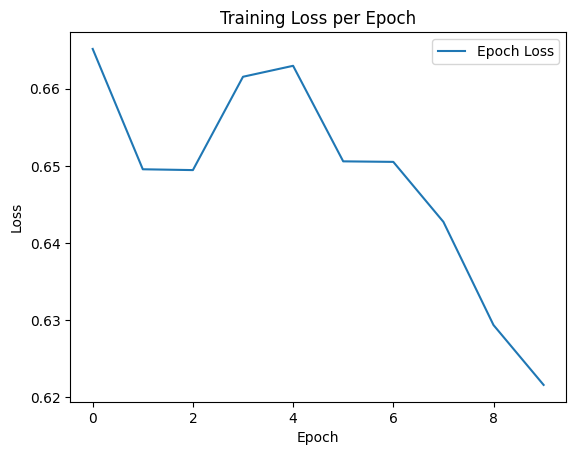

In [31]:
plt.plot(train_loss, label = 'Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

In [32]:
# Checking the overall accuracy of the model on the validation set.
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct // total} %')

Accuracy of the network on the validation images: 81 %


In [33]:
# Checking the accuracy for each class on the validation set.
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Pukeko is 90.1 %
Accuracy for class: Takahe is 25.3 %


In [ ]:
precision = precision_score(labels, predicted)
recall = recall_score(labels, predicted)
f1 = f1_score(labels, predicted)
print(f'Precision for class: {classname:5s} is {precision:.1f} %')
print(f'Recall for class: {classname:5s} is {recall:.1f} %')
print(f'F1 score for class: {classname:5s} is {f1:.1f} %')


In [ ]:
precision_weighted = precision_score(labels, predicted, average = 'weighted')
precision_macro = precision_score(labels, predicted, average = 'macro')
print("Macro Precision:", precision_macro)
print("Weighted Precision:", precision_weighted)

In [ ]:
recall_weighted = recall_score(labels, predicted, average = 'weighted')
recall_macro = recall_score(labels, predicted, average = 'macro')
print("Macro recall:", recall_macro)
print("Weighted recall:", recall_weighted)

In [ ]:
f1_weighted = f1_score(labels, predicted, average = 'weighted')
f1_macro = f1_score(labels, predicted, average = 'macro')
print("Macro F1 score:", f1_weighted)
print("Weighted F1 score:", f1_macro)

In [ ]:
# PATH = 'Models/modelA.pth'
# torch.save(model.state_dict(), PATH)